# Capstone Week 2
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
- [Feature Engineering](#Feature-Engineering)
    - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
- [Residuals](#Residuals)
- [Classification](#Classification)
- [Model Interpretation](#Model-Interpretation)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
# df = pd.read_excel(
#     '../Transaction_Data_20210128.xlsx', 
#     sheet_name='36 Rolling Months',
#     usecols='B:AN',
#     header=1,
#     skiprows=0
# )
# df.to_csv('../Transactions.csv', index=False)

In [ ]:
df = pd.read_csv('../Transactions.csv', parse_dates=['refresh_date'])
df.head()

In [ ]:
firms = pd.read_csv("../Firms.csv")

## Make advisor dictionary mapper

In [8]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [9]:
adviser_lookup[10]

'0082583'

# Combine `sales_curr` and `sales_12M`

In [10]:
df['total_sales'] = df['sales_curr'] + df['sales_12M']

# Data Cleaning

Before you change ANYTHING with the data - besides the above :) - do your train-test split

In [11]:
FEATURES = [
    'CONTACT_ID', 'no_of_sales_12M_1', 'no_of_Redemption_12M_1',
    'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
    'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
    'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
    'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
    'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
    'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M',
    'redemption_rate', 'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 'refresh_date',
]
TARGETS = 'total_sales'

## Partition training and testing

In [12]:
training_rows = df['refresh_date'].dt.year.isin([2017, 2018, 2019])
testing_rows = df['refresh_date'].dt.year.isin([2020])

X = df.loc[training_rows, FEATURES].copy()
y_reg = df.loc[training_rows, TARGETS].copy()
y_cl = df.loc[training_rows, 'new_Fund_added_12M'].copy()

y_holdout_test = df.loc[testing_rows, TARGETS].copy() # forget about this for now

[Back to Top](#Index)
# Data Cleaning

In [13]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'CONTACT_ID', 'sales_curr', 'sales_12M', 
    'refresh_date', 'new_Fund_added_12M','no_of_Redemption_12M_1',
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 
    'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
    'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
    'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
    'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
    'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
    'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'redemption_curr', 
    'redemption_12M', 'redemption_rate', 'aum_AC_EQUITY', 
    'aum_AC_FIXED_INCOME_MUNI', 'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 
    'aum_AC_MULTIPLE', 'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 
    'aum_AC_TARGET', 'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 
    'aum_P_MF', 'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT',
]

## Train-Test-Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [16]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(series):
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [18]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [19]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans)
])

y_train_reg = targ_pipe_reg.fit_transform(y_train_reg.to_frame()).squeeze()
y_test_reg = targ_pipe_reg.transform(y_test_reg.to_frame()).squeeze()

In [20]:
y_test_reg.head()

228198    269083.425
240133      3578.970
163658      9497.900
176954         0.000
69498      30529.080
Name: total_sales, dtype: float64

Transform the classification target

In [21]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)
y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)
y_test_cl

228198    1
240133    1
163658    1
176954    0
69498     1
         ..
239268    0
116033    0
238773    1
7527      1
11875     0
Length: 75075, dtype: int64

Create the pipeline for the features

In [22]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [23]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [24]:
X_test_prepared

,no_of_sales_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,redemption_curr,redemption_12M,redemption_rate,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
228198,0.419353,-0.022344,-0.131470,2.023584,0.626532,0.340508,-0.437077,2.278578,2.054430,0.908770,-0.553380,0.908777,1.979170,0.019918,0.068295,0.089322,0.004082,0.041528,-0.006796,0.093585,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,0.074945,-0.063369,-0.019221,-0.071324
240133,0.017653,-0.143413,0.016215,0.297495,0.212339,-0.422192,1.073676,0.245910,0.122282,-0.529555,0.829793,-0.688053,-0.887621,-0.159247,0.068295,0.059408,0.004082,-0.025713,-0.154584,-0.056329,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.136494,-0.063369,-0.019221,-0.071324
163658,-0.112629,-0.143413,0.090058,0.729017,0.212339,-0.422192,1.073676,1.262244,1.088356,-0.529555,2.212966,-0.368687,0.067976,-0.098802,0.004529,0.034848,0.004040,-0.154230,-0.013494,-0.063579,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.153778,0.089634,-0.019221,-0.071324
176954,-0.199483,-0.143413,-0.131470,-0.565550,-0.616045,-0.422192,-0.437077,-0.770424,-0.843792,-0.529555,-0.553380,-0.688053,-0.887621,-0.106060,0.068295,0.116656,0.004082,-0.024697,-0.092124,-0.051421,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.073726,-0.063369,-0.019221,-0.071324
69498,-0.156056,-0.082878,-0.131470,0.729017,-0.616045,0.340508,-0.437077,2.278578,-0.843792,0.908770,-0.553380,0.589411,1.979170,-0.089836,0.068295,0.116656,0.004082,-0.015079,-0.079895,-0.040903,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.054579,-0.063369,-0.019221,-0.071324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239268,-0.177769,-0.143413,-0.131470,-0.134027,-0.201853,-0.422192,-0.437077,0.245910,0.122282,-0.529555,-0.553380,-0.688053,-0.887621,-0.106144,0.068295,0.110451,0.004082,-0.022837,-0.092124,-0.056240,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.073825,-0.063369,-0.019221,-0.071324
116033,-0.199483,-0.143413,-0.131470,-0.565550,-0.616045,-0.422192,-0.437077,-0.770424,-0.843792,-0.529555,-0.553380,-0.688053,-0.887621,-0.105259,0.068295,0.116656,0.004082,-0.022837,-0.092124,-0.051421,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.072781,-0.063369,-0.019221,-0.071324
238773,-0.134342,-0.143413,0.533113,1.160539,4.354262,-0.422192,6.361310,1.262244,2.054430,-0.529555,3.596140,0.270045,-0.887621,-0.355428,-0.340934,-0.655012,0.004089,-0.347423,-0.122949,-0.513231,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,-0.368013,-0.063369,-0.019221,-0.071324
7527,0.082793,0.098725,0.016215,1.592062,0.626532,2.628608,1.073676,2.278578,1.088356,3.785420,2.212966,0.589411,1.979170,-0.042926,0.066781,0.069100,0.004082,0.036048,-0.050406,-0.038648,-0.006865,-0.022982,-0.038146,-0.028802,-0.041777,-0.075385,-0.025897,-0.086053,-0.01376,0.000782,-0.063369,-0.019221,-0.071324


[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb

In [26]:
lr = LinearRegression()
lr.fit(X_train_prepared, y_train_reg)

LinearRegression()

In [27]:
from sklearn.model_selection import cross_validate

In [28]:
-cross_validate(
    lr, 
    X_train_prepared, 
    y_train_reg, 
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)['test_score']

array([519361.60718704, 580940.66300179, 527752.70541477])

Make a plot of predictions vs actual

In [29]:
y_test_reg_preds = lr.predict(X_test_prepared)

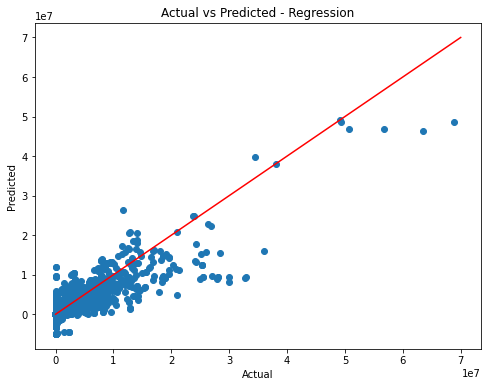

In [30]:
fig, axes = plt.subplots(figsize=(8, 6))

axes.scatter(x=y_test_reg, y=y_test_reg_preds)

axes.plot([0, 70000000], [0,70000000], c='r')
axes.set_title("Actual vs Predicted - Regression")
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted");

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


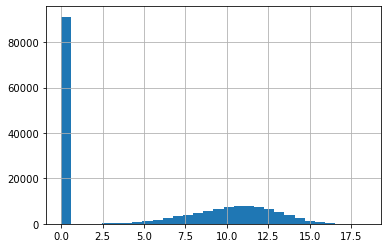

In [31]:
np.log1p(y_train_reg).hist(bins=30);

In [32]:
def evaluate_model(model, X, y):
    print("Cross Validation Scores:")
    print(cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
    print('-'*55)
    preds = model.predict(X)
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, 70000000], [0, 70000000])
    ax.set_xlim([0, 70000000])
    ax.set_ylim([0, 70000000])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

Cross Validation Scores:
[  -603623.76203374   -463245.02875485   -579273.43385118
 -56518566.35925348   -553445.14640968]
-------------------------------------------------------


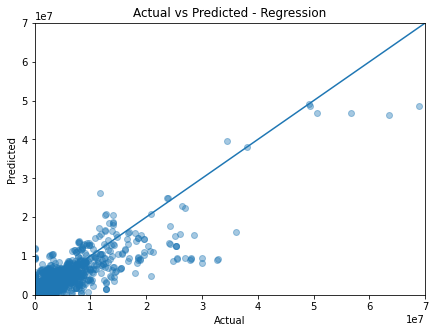

In [33]:
evaluate_model(lr, X_test_prepared, y_test_reg)